# Imports

In [2]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

# Define Model

In [88]:
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))
        
        if self.training:
            return upconv1
        else:
            pred = torch.sigmoid(upconv1) > 0.5 
            return pred.squeeze(0).squeeze(0)
        
    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

## Load Torch Model

In [89]:
torch_model= '../unet.pth'
unet = UNET(4,1)
unet.load_state_dict(torch.load(torch_model))
unet.eval()
x = torch.randn(1, 4, 224, 224, requires_grad=True)
torch_out = unet(x)
torch_out.shape

torch.Size([224, 224])

## Run one Example

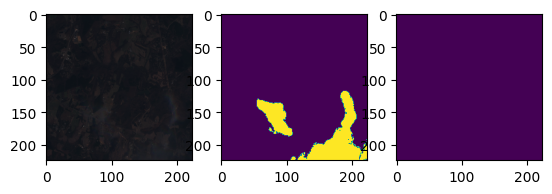

In [90]:
image_path = '../data/images_patches/img_18_patch_16.npy'
mask_path = '../data/masks_patches/mask_18_patch_16.npy'

img = np.load(image_path)
mask = np.load(mask_path)

img_inp = torch.from_numpy(img).permute(2,0,1).unsqueeze(0)
img_inp = (img_inp - img_inp.mean())/img_inp.std()

pred = unet(img_inp)

plt.subplot(1,3,1)
plt.imshow(img[:,:,[0,1,2]]) # for visualization we have to transpose back to HWC
plt.subplot(1,3,2)
plt.imshow(mask) # for visualization we have to remove 3rd dimension of mask
plt.subplot(1,3,3)
plt.imshow(pred.numpy()) 
plt.show()

## ONNX Inference

In [91]:
import onnx
import onnxruntime
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [92]:
def to_numpy(tensor):
        return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()
def preprocess(img):
        img = torch.from_numpy(img).cpu().permute(2,0,1).unsqueeze(0)
        img = (img - img.mean())/img.std()
        return img.numpy()
        

In [95]:
onnx_model = '../unet.onnx'

        
onnx_model = onnx.load(onnx_model)
onnx.checker.check_model(onnx_model)

### onnx runtime ###
ort_session = onnxruntime.InferenceSession(onnx_model.SerializeToString())
        
# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: preprocess(img)}
ort_outs = ort_session.run(None, ort_inputs)

FileNotFoundError: [Errno 2] No such file or directory: '../unet.onnx'

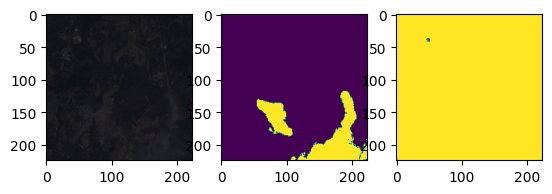

In [94]:
plt.subplot(1,3,1)
plt.imshow(img[:,:,[0,1,2]]) # for visualization we have to transpose back to HWC
plt.subplot(1,3,2)
plt.imshow(mask) # for visualization we have to remove 3rd dimension of mask
plt.subplot(1,3,3)
plt.imshow(ort_outs[0]) 
plt.show()